### 2.1 A 2-layer NN example on MNIST written in Keras

下面是一个两层全连接层的神经网络在Keras框架中的实例，我们将用其解决最为经典的MNIST数据集上的手写数字识别问题。

In [1]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

C:\Users\10750\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_images.shape

(60000, 28, 28)

keras.datasets中预置了许多经典的数据集，当然第一次load_data()时是需要下载到本地的。load_data方法返回格式为Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

下面是keras中网络架构的写法，核心是keras.layers中的网络层的组装。即将简单的层链接起来，从而实现渐进式的数据蒸馏(data distillation)。

Dense是keras中的全连接层，在pytorch等框架中也叫fc。

In [3]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28*28, )))
network.add(layers.Dense(10, activation='softmax'))

In [4]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


在训练网络之前，我们还需要选择compile步骤的三个参数，它们分别是

- loss function
- optimizer
- metric

In [5]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

在把训练数据feed进network之前，我们先对原始数据进行处理：将(60000, 28, 28)的数据拉成(60000, 28 * 28)，并把dtype从uint8变成float32，并把数据范围normalize到(0,1)的区间中。

In [6]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

In [7]:
# 对图像标签进行编码
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 12s 206us/step - loss: 0.2563 - acc: 0.9260
Epoch 2/5
60000/60000 [==============================] - 4s 72us/step - loss: 0.1043 - acc: 0.9694
Epoch 3/5
60000/60000 [==============================] - 5s 76us/step - loss: 0.0690 - acc: 0.9795
Epoch 4/5
60000/60000 [==============================] - 6s 100us/step - loss: 0.0498 - acc: 0.9852 1s - loss: 0.0493 - acc: 0.985 - ETA: 1s - loss: 0.049 - ETA: 1s - loss:  - ETA: 0s - loss: 0.
Epoch 5/5
60000/60000 [==============================] - 5s 79us/step - loss: 0.0379 - acc: 0.9883A: 9s - loss: 0.0370 - acc


可以看到，train了5个epoch后在训练集上的accuracy是98.83%，下面用evaluate方法将network在测试集上测试：

In [9]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 87us/step


In [10]:
test_acc

0.9816

### 2.2 Data representations in Neural Networks

神经网络中的数据表示，简而言之，就是张量(Tensor)。tensor是一个数据容器，可以看作是向量或矩阵向任意维度的推广，其维度也叫轴(axis)，x.ndim即其张量的维度数。0D张量就是一个数，也称标量。

In [11]:
train_images.ndim

2

张量是由以下三个属性决定的：
- Numbers of axes(rank)，也即ndim维数
- Shape，x.shape查看
- Data type，如float32/uint8等

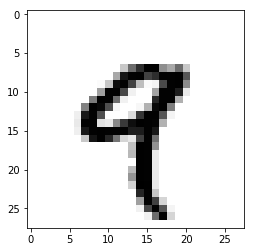

In [14]:
digit = train_images[4].reshape(28, 28)

import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

需要注意的一点是，大部分深度学习框架中都默认数据的第一个axis是batch axis，其在数值上等于samples的个数。

这一设定重要的地方在于，在框架拿数据fit模型的时候，会根据batch_size在数据上slice，如batch = train_images[:128]

### 2.3 The gears of neural networks: tensor operations

本质上说，神经网络做的就是数值张量上的张量运算(tensor operation)。下面分类来看这些运算：

- Element-wise逐元素运算，如relu, add等。运算独立作用于张量中每个元素，适合大规模并行实现。
- Broadcasting广播，如将(32, 10)的张量和(10, )相加时，会把(10, )先添加broadcasting axis变为(1, 10)，再将其沿着新的axis重复32次变为(32, 10)再和第一个张量相加。
- Tensor dot张量点积，在keras中的实现和numpy一样，用np.dot(x, y)。
- Tensor reshaping张量变形，x.reshape可以改变shape，但总元素个数不变。np.transpose(x)可以实现x的转置，作为一种特殊的reshape。

深度学习的内容可以被理解为：通过tensor operations为复杂的、高维的数据流形找到简洁的表示。

### 2.4 The engine of neural networks: gradient-based optimization

神经网络训练的过程：将一个batch的数据feed到模型中，在x上做forward pass得到y_pred，计算y_pred和y之间的distance作为loss，更新神经网络的weights使loss下降。

最后一步，即backward pass是训练的关键所在。BP利用了网络中所有运算都是可微的事实，计算loss相对于网络系数的gradient，然后向gradient的相反方向改变weights，从而使loss降低。

#### 随机梯度下降SGD

SGD对于参数的更新即最简单的W -= learning_rate * gradient。而SGD的随机(stochastic)就在于每次batch是随机抽取的。根据batch大小不同，SGD分为以下几种：每次用一个固定batch_size的随机batch做GD的mini-batch SGD、每次只用一个sample做SGD的true SGD和每次把所有sample当一个batch的batch SGD。虽然batch SGD最为准确，但计算代价要高出很多，因此一般还是选择合适size的mini-batch。